In [200]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns 

In [201]:
df_customers = pd.read_csv ("./archive/olist_customers_dataset.csv")
df_geolocation = pd.read_csv ("./archive/olist_geolocation_dataset.csv")
df_order_items = pd.read_csv ("./archive/olist_order_items_dataset.csv")
df_order_payments = pd.read_csv ("./archive/olist_order_payments_dataset.csv") 
df_order_reviews = pd.read_csv ("./archive/olist_order_reviews_dataset.csv") 
df_orders = pd.read_csv ("./archive/olist_orders_dataset.csv")
df_products = pd.read_csv ("./archive/olist_products_dataset.csv")
df_sellers = pd.read_csv ("./archive/olist_sellers_dataset.csv") 
df_category_name_translation = pd.read_csv ("./archive/product_category_name_translation.csv")

In [202]:
import pickle
data_costumers = pd.read_pickle(r'C:\Users\chouc\openclassrooms\projet 5\model\data_costumers.pickle')

In [210]:
data_costumers_final = pd.read_pickle(r'C:\Users\chouc\openclassrooms\projet 5\model\data_costumers_final.pickle')


<h3><center><font color='green'>RFM Modelling</font></center></h3>

- Recency = Date depuis la derniére Date d'achat 
- Frequency = Nombre d'achats efféctués par chaque client 
- Monetary = La somme totale que chaque client a payé

In [137]:
import datetime as dt

In [138]:
#Définir la date de la derniére commande .Il s'agit de calculer le nombre de jours depuis l'achat récent
Latest_Date = dt.datetime(2022,8,10) 

In [139]:
#Creer RFM scores pour chaque  client
RFMScores = data_costumers.groupby('customer_unique_id').agg({'order_purchase_timestamp': lambda x: (Latest_Date - x.max()).days, 'order_id': lambda x: len(x), 'payment_value': lambda x: x.sum()})

In [140]:
#Convertir la date de la commande au type int
RFMScores['order_purchase_timestamp'] = RFMScores['order_purchase_timestamp'].astype(int)

In [141]:
#Renomer les colonnes :  Recency, Frequency and Monetary
RFMScores.rename(columns={'order_purchase_timestamp': 'Recency', 
                         'order_id': 'Frequency', 
                         'payment_value': 'Monetary'}, inplace=True)

In [142]:
RFMScores.reset_index().head()

,customer_unique_id,Recency,Frequency,Monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,1552,1,141.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1555,1,27.19
2,0000f46a3911fa3c0805444483337064,1978,1,86.22
3,0000f6ccb0745a6a4b88665a16c9f078,1762,1,43.62
4,0004aac84e0df4da2b147fca70cf8255,1729,1,196.89


In [143]:
#Descriptive Statistique (Recency)
RFMScores.Recency.describe()

count    94707.000000
mean      1679.305363
std        153.146624
min       1436.000000
25%       1555.000000
50%       1660.000000
75%       1788.000000
max       2165.000000
Name: Recency, dtype: float64

C:\Users\chouc\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



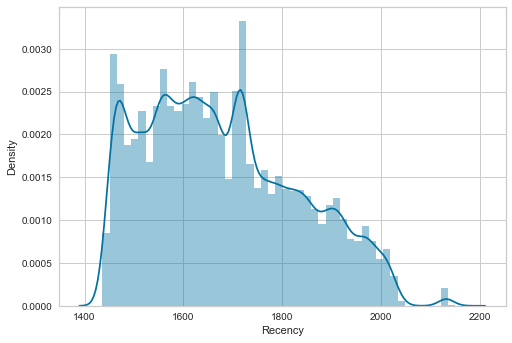

In [144]:
#Recency distribution plot
import seaborn as sns
x = RFMScores['Recency']

ax = sns.distplot(x)

In [145]:
#Descriptive Statistique (Frequency)
RFMScores.Frequency.describe()


count    94707.000000
mean         1.234228
std          0.833644
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         75.000000
Name: Frequency, dtype: float64

C:\Users\chouc\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



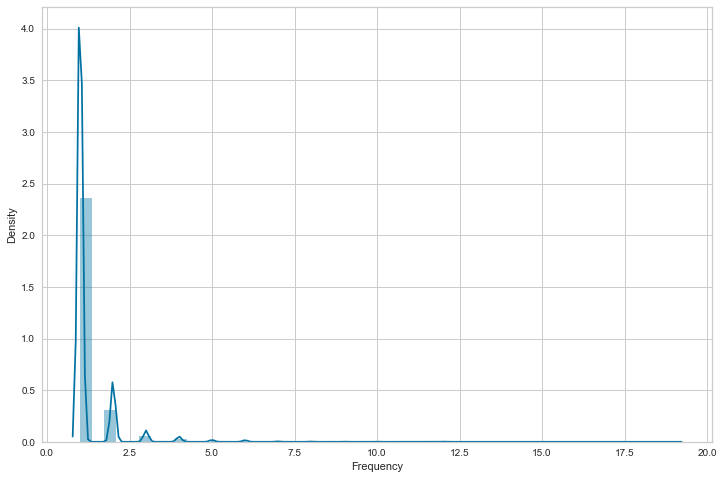

In [146]:
#Frequency distribution plot, 
fig = plt.figure(figsize=(12,8))
x = RFMScores.query('Frequency < 20')['Frequency']

ax = sns.distplot(x)

In [147]:
#Descriptive Statistique (Monetary)
RFMScores.Monetary.describe()

count     94707.000000
mean        212.481051
std         627.386092
min           9.590000
25%          63.880000
50%         113.110000
75%         202.220000
max      109312.640000
Name: Monetary, dtype: float64

C:\Users\chouc\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



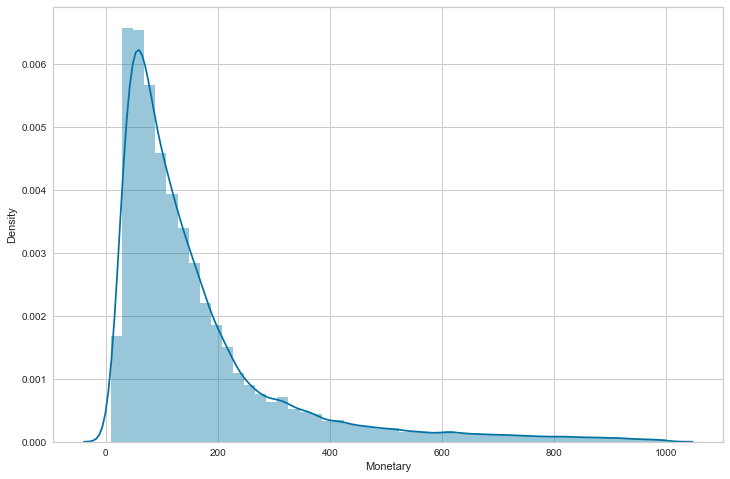

In [148]:
#Monateray distribution plot,
fig = plt.figure(figsize=(12,8))
x = RFMScores.query('Monetary < 1000')['Monetary']
ax = sns.distplot(x)

In [149]:
#diviser sur 4 segments en quantiles
quantiles = RFMScores.quantile(q=[0.25,0.5,0.75])
quantiles = quantiles.to_dict()

In [150]:
quantiles

{'Recency': {0.25: 1555.0, 0.5: 1660.0, 0.75: 1788.0},
 'Frequency': {0.25: 1.0, 0.5: 1.0, 0.75: 1.0},
 'Monetary': {0.25: 63.88, 0.5: 113.11, 0.75: 202.22}}

In [151]:
#Functions pour créer R, F et M segments
def RScoring(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4
    
def FnMScoring(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1

In [152]:
#Ajouter des colonnes de valeur de segment R, F et M dans l'ensemble de données existant pour afficher les valeurs de segment R, F et M
RFMScores['R'] = RFMScores['Recency'].apply(RScoring, args=('Recency',quantiles,))
RFMScores['F'] = RFMScores['Frequency'].apply(FnMScoring, args=('Frequency',quantiles,))
RFMScores['M'] = RFMScores['Monetary'].apply(FnMScoring, args=('Monetary',quantiles,))
RFMScores.head()

,Recency,Frequency,Monetary,R,F,M
customer_unique_id,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,1552,1,141.90,1,4,2
0000b849f77a49e4a4ce2b2a4ca5be3f,1555,1,27.19,1,4,4
0000f46a3911fa3c0805444483337064,1978,1,86.22,4,4,3
0000f6ccb0745a6a4b88665a16c9f078,1762,1,43.62,3,4,4
0004aac84e0df4da2b147fca70cf8255,1729,1,196.89,3,4,2


In [153]:
# Calculer et ajouter une colonne de valeurs RFMGroup indiquant le score concaténé combiné de RFM
RFMScores['RFMGroup'] = RFMScores.R.map(str) + RFMScores.F.map(str) + RFMScores.M.map(str)

#Calculer et ajouter une colonne de valeurs RFMScore indiquant la somme totale des valeurs RFMGroup
RFMScores['RFMScore'] = RFMScores[['R', 'F', 'M']].sum(axis = 1)
RFMScores.head()

,Recency,Frequency,Monetary,R,F,M,RFMGroup,RFMScore
customer_unique_id,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,1552,1,141.90,1,4,2,142,7
0000b849f77a49e4a4ce2b2a4ca5be3f,1555,1,27.19,1,4,4,144,9
0000f46a3911fa3c0805444483337064,1978,1,86.22,4,4,3,443,11
0000f6ccb0745a6a4b88665a16c9f078,1762,1,43.62,3,4,4,344,11
0004aac84e0df4da2b147fca70cf8255,1729,1,196.89,3,4,2,342,9


In [154]:
#Attribuer un niveau de fidélité à chaque client
Loyalty_Level = ['Platinum', 'Gold', 'Silver', 'Bronze']
Score_cuts = pd.qcut(RFMScores.RFMScore, q = 4, labels = Loyalty_Level)
RFMScores['RFM_Loyalty_Level'] = Score_cuts.values
RFMScores.reset_index().head()

,customer_unique_id,Recency,Frequency,Monetary,R,F,M,RFMGroup,RFMScore,RFM_Loyalty_Level
0,0000366f3b9a7992bf8c76cfdf3221e2,1552,1,141.90,1,4,2,142,7,Platinum
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1555,1,27.19,1,4,4,144,9,Gold
2,0000f46a3911fa3c0805444483337064,1978,1,86.22,4,4,3,443,11,Bronze
3,0000f6ccb0745a6a4b88665a16c9f078,1762,1,43.62,3,4,4,344,11,Bronze
4,0004aac84e0df4da2b147fca70cf8255,1729,1,196.89,3,4,2,342,9,Gold


#### RFM : K-Means Clustering

In [155]:
#ramener les données dans une distribution normale
Log_Tfd_Data = RFMScores[['Recency', 'Frequency', 'Monetary']].apply(np.log, axis = 1).round(3)

C:\Users\chouc\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



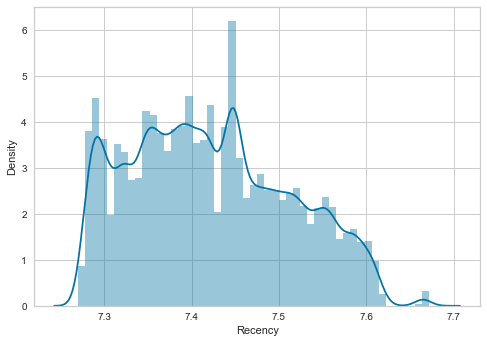

In [156]:
# Distribution des données après normalisation des données pour : Recency
Recency_Plot = Log_Tfd_Data['Recency']
ax = sns.distplot(Recency_Plot)

C:\Users\chouc\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



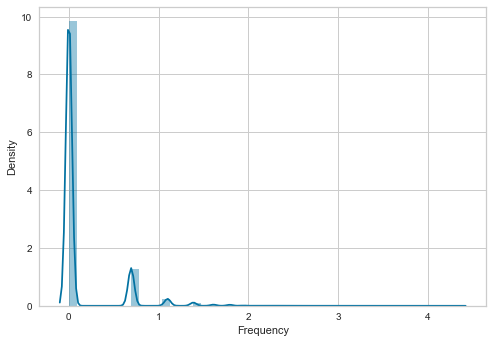

In [157]:
#Distribution des données après normalisation des données pour : 'Frequency'
Frequency_Plot = Log_Tfd_Data.query('Frequency < 1000')['Frequency']
ax = sns.distplot(Frequency_Plot)

C:\Users\chouc\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



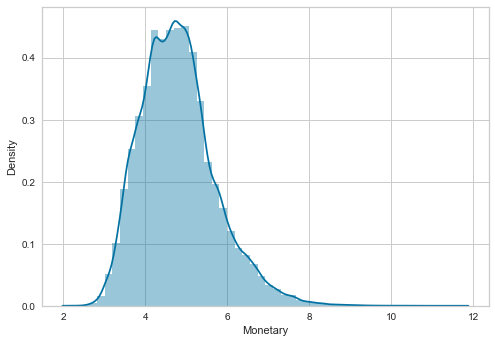

In [158]:
#Distribution des données après normalisation des données pour : Monetary
Monetary_Plot = Log_Tfd_Data.query('Monetary < 10000')['Monetary']
ax = sns.distplot(Monetary_Plot)

In [159]:
numerical_features = ['Recency','Frequency','Monetary']

In [160]:
from sklearn.preprocessing import StandardScaler

#Amenez les données à la même échelle
scaleobj = StandardScaler()
Scaled_Data = scaleobj.fit_transform(Log_Tfd_Data)

#Transformez-les en dataframe
Scaled_Data = pd.DataFrame(Scaled_Data, index = RFMScores.index, columns = Log_Tfd_Data.columns)

In [161]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer, make_column_transformer
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer, InterclusterDistance
from sklearn.cluster import KMeans

In [162]:
# scaler = MinMaxScaler()

# preprocessor = ColumnTransformer([
#     ('scaler', scaler, numerical_features)])

In [163]:
# # X = Scaled_Data.copy()

# # # Elbow method
# # kmeans_visualizer = Pipeline([
# #     ("preprocessor", preprocessor),
# #     ("kelbowvisualizer", KElbowVisualizer(KMeans(),K=(1,12)))])
# # kmeans_visualizer.fit(X)
# kmeans_visualizer.named_steps['kelbowvisualizer'].show()

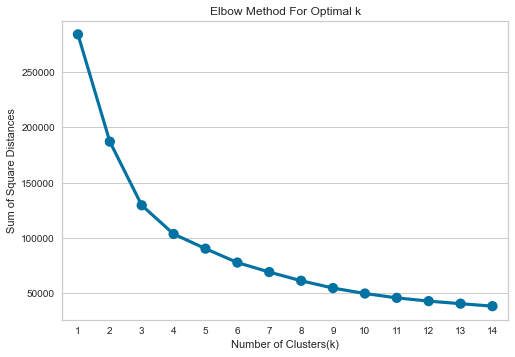

In [164]:

sum_of_sq_dist = {}
for k in range(1,15):
    km = KMeans(n_clusters= k, init= 'k-means++', max_iter= 1000)
    km = km.fit(Scaled_Data)
    sum_of_sq_dist[k] = km.inertia_
    
#Plot the graph for the sum of square distance values and Number of Clusters

sns.pointplot(x = list(sum_of_sq_dist.keys()), y = list(sum_of_sq_dist.values()))
plt.xlabel('Number of Clusters(k)')
plt.ylabel('Sum of Square Distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [169]:
#construire le modèle de clustering K-Means
KMean_clust = KMeans(n_clusters= 4, init= 'k-means++', max_iter= 1000)
KMean_clust.fit(Scaled_Data)


# Trouver les clusters pour l'ensemble de données
RFMScores['Cluster'] = KMean_clust.labels_
RFMScores.head()


,Recency,Frequency,Monetary,R,F,M,RFMGroup,RFMScore,RFM_Loyalty_Level,Cluster
customer_unique_id,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,1552,1,141.90,1,4,2,142,7,Platinum,2
0000b849f77a49e4a4ce2b2a4ca5be3f,1555,1,27.19,1,4,4,144,9,Gold,0
0000f46a3911fa3c0805444483337064,1978,1,86.22,4,4,3,443,11,Bronze,1
0000f6ccb0745a6a4b88665a16c9f078,1762,1,43.62,3,4,4,344,11,Bronze,1
0004aac84e0df4da2b147fca70cf8255,1729,1,196.89,3,4,2,342,9,Gold,2


In [181]:
RFMScores['Monetary'].max()

109312.64

In [182]:
RFMScores['Monetary'].median()

113.11

In [183]:
RFMScores['Recency'].max()

2165

In [184]:
RFMScores['Recency'].median()

1660.0

In [195]:
RFMScores[RFMScores['Cluster']==1].max()

Recency                 2165
Frequency                  3
Monetary             1438.23
R                          4
F                          4
M                          4
RFMGroup                 444
RFMScore                  12
RFM_Loyalty_Level     Bronze
Cluster                    1
dtype: object

In [196]:
RFMScores[RFMScores['Cluster']==1].median()

C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_19852\1221286600.py:1: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



Recency      1845.000
Frequency       1.000
Monetary       91.515
R               4.000
F               4.000
M               3.000
RFMGroup      442.000
RFMScore       10.000
Cluster         1.000
dtype: float64

Les clients du cluster 0 : Sont des mauvais clients : Ils ont effectués un trés petit nombre d'achats, avec des petits budgets et ils ne sont pas des clients fidéles.

Les clients du cluster 1 : Des clients passagers : Ils ont effectués maximum 3 achats avec des budgets trés variés. 

Les clients du cluster 2 :  sont des clients dépenseurs : qui n'achétent pas fréquement mais qui dépensent des grands montants lors de leurs achats effectués sur le site OLIST.

Les clients du cluster 3 : Sont des clients potentiels: Il achétent trés fréquements, avec des grands budgets et ont acheté récement

                                                      =============
                                                      =============

<h3><center><font color='green'>Clustering avec l'algorithme du K-Means</font></center></h3>

#### Preprocessing

In [206]:
data_costumers_final.drop(columns= 'customer_unique_id', inplace= True)

- Convertir les variable catégorielles en variables indicatrices (numériques) :

In [207]:
df1 = pd.get_dummies(data_costumers_final['product_category_name_english'], prefix='pc')
df1.reset_index(drop=True, inplace=True)

In [208]:
numerical_features = ['payment_value','review_score','payment_installments','order_purchase_hour','freight_value','payment_sequential','distance_from_olist','delais_de_livraison']

In [211]:
data_costumers_final[numerical_features].reset_index(drop=True, inplace=True)

In [212]:
data_costumers_final.reset_index(drop=True, inplace=True)

In [213]:
data_costumers_final2 = pd.concat([data_costumers_final[numerical_features],df1], axis=1, join="outer")

- KMeans

In [214]:
from sklearn.cluster import KMeans

In [215]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer, make_column_transformer
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer, InterclusterDistance

In [216]:
numerical_features = list(data_costumers_final2.select_dtypes(include=['int64','float64', 'uint8']).columns)

In [217]:
scaler = MinMaxScaler()

preprocessor = ColumnTransformer([
    ('scaler', scaler, numerical_features)])

#### Méthode du coude : détermination du meilleur K :

- Un pipeline SKLearn est créé pour y inclure le preprocessing et la visualisation de la méthode du coude de notre KMeans.

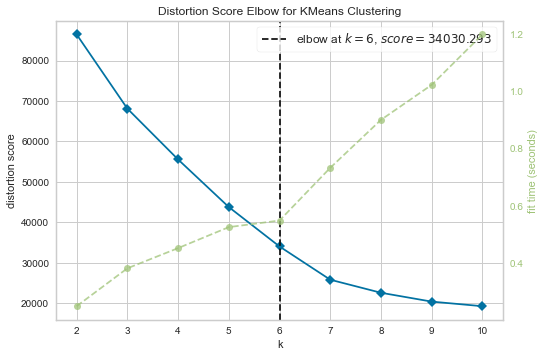

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [218]:
X = data_costumers_final2.copy()

# Elbow method
kmeans_visualizer = Pipeline([
    ("preprocessor", preprocessor),
    ("kelbowvisualizer", KElbowVisualizer(KMeans(),K=(1,12)))])
kmeans_visualizer.fit(X)
kmeans_visualizer.named_steps['kelbowvisualizer'].show()

Grâce à la méthode du coude basée sur le score de distortion (somme moyenne des carrés des distances aux centres), une segementation en K= 6 clusters serait la meilleure option.

#### Coefficient de silhouette

Pour vérifier si ce clustering fonctionne, nous allons utiliser SilhouetteVisualizer pour afficher le coefficient de silhouette pour un échantillonage de chaque cluster. Cela permet de visualiser la densité et la séparation des clusters.

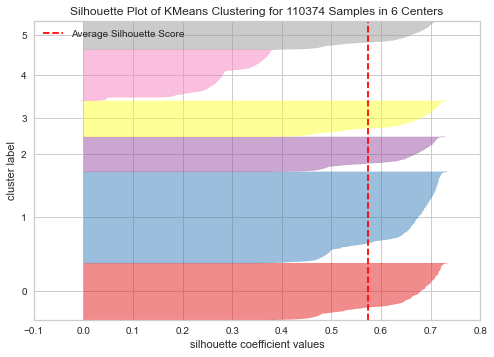

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 110374 Samples in 6 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [219]:
# Best K in Elbow
K = kmeans_visualizer.named_steps['kelbowvisualizer'].elbow_value_

# Silhouette Visualizer
silhouette_visualizer = Pipeline([
    ("preprocessor", preprocessor),
    ("silhouettevisualizer", SilhouetteVisualizer(KMeans(K)))])
silhouette_visualizer.fit(X)
silhouette_visualizer.named_steps['silhouettevisualizer'].show()

Le score de chaque échantillon est calculé en faisant la moyenne du coefficient de silhouette (différence entre la distance moyenne intra-cluster et la distance moyenne du cluster le plus proche pour chaque échantillon), normalisée par la valeur maximale. Cela nous donne un score entre -1 et 1, qui nous permet de déterminer si la séparation est efficace ou si les points sont assignés au mauvais cluster.

Ici, les clusters semblent relativement bien répartis et les séparations sont claires avec cependant quelques erreurs sur l'un des clusters.

A présent, nous allons tester d'autres types de métriques pour trouver le meilleur K :

Silouhette : rapport moyen entre la distance intra-cluster et la distance du cluster le plus proche, Calinski Harabasz : rapport entre la dispersion des grappes dans et entre les groupes.

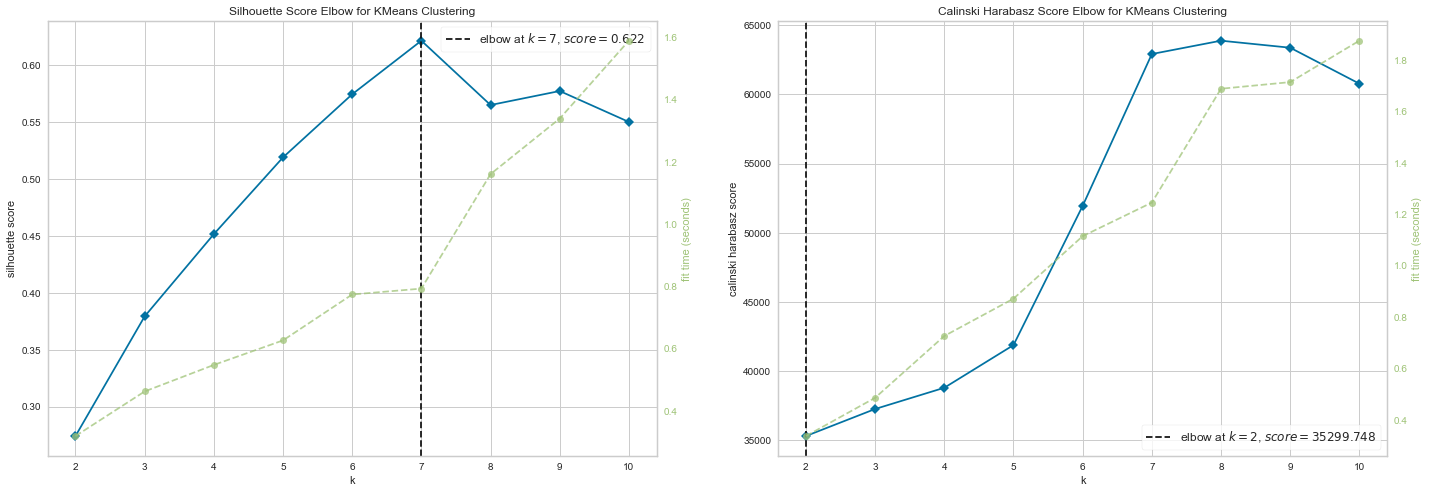

In [220]:
# Elbow method with differents metrics
metrics = ["silhouette", "calinski_harabasz"]
i = 0

fig, axes = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(24,8))
for m in metrics:
    kmeans_visualizer = Pipeline([
        ("preprocessor", preprocessor),
        ("kelbowvisualizer", KElbowVisualizer(KMeans(),
                                              K=(4,10),
                                              metric=m,
                                              ax=axes[i]))])
    kmeans_visualizer.fit(X)
    kmeans_visualizer.named_steps['kelbowvisualizer'].finalize()
    i+=1

plt.show()

On remarque ici que pour la métrique silhouette score, le nombre de K est également de 6. Pour le score Calinski Harabasz, le meilleur K est plus incertain. Les scores sur la répartition en 6 clusters semblent être meilleurs. Nous allons donc conserver ce clustering en 6 groupes.

#### Distances intercluster

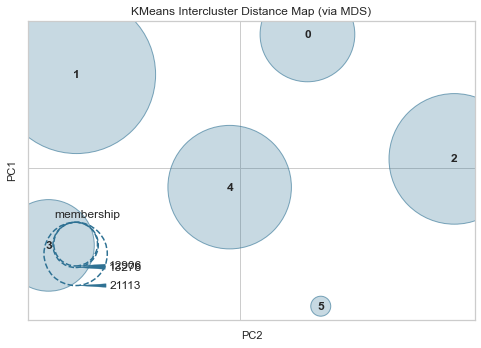

<AxesSubplot:title={'center':'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>

In [221]:
# Intercluster distance Map with best k
distance_visualizer = Pipeline([
    ("preprocessor", preprocessor),
    ("distancevisualizer", InterclusterDistance(KMeans(K)))])
distance_visualizer.fit(X)
distance_visualizer.named_steps['distancevisualizer'].show()

Sur cette projection en 2D, on remarque que les différents clusters sont bien séparés sur les 2 premières composantes principales. Le clustering semble donc performant et il faut a présent identifier les composantes métier de chaque cluster.

#### Analyse des différents clusters

A présent, nous allons entrainer notre KMeans avec le K optimal sélectionné et affecter son cluster à chaque client. Ainsi, nous pourrons analyser les différences entre chaque cluster :

In [222]:
# KMeans Pipeline with best K
kmeans_model = Pipeline([("preprocessor", preprocessor),
                         ("kmeans", KMeans(K))])
kmeans_model.fit(X)

# Kmeans labels
kmeans_labels = kmeans_model.named_steps['kmeans'].labels_
data_costumers_final2["kmeans_label"] = kmeans_labels

Nous allons dans un premier temps grouper les individus par cluster pour analyser les moyennes :

In [223]:
kmeans_clusters_means = data_costumers_final2.groupby("kmeans_label").mean().reset_index()
kmeans_clusters_means

,kmeans_label,payment_value,review_score,payment_installments,order_purchase_hour,freight_value,payment_sequential,distance_from_olist,delais_de_livraison,"pc_Books, CDs and other physical media","pc_Fashion, clothing and accesories",pc_Flowres and gifts,"pc_Groceries, food and drink",pc_Health and beauty,pc_Home and furniture,pc_Other,pc_Technology,pc_Toys and baby equipment
0,0,343.932982,4.034052,4.412056,14.718426,37.791628,1.882613,439.251668,10.835503,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,1.0
1,1,283.204594,4.126073,4.543741,14.696301,34.206909,1.666414,436.009275,9.770142,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1.0,0.0,0.0
2,2,298.431651,4.018073,5.926186,14.852046,39.004542,2.092067,398.341031,10.367020,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.0,0.0,0.0
3,3,283.439469,4.105894,4.969361,14.732964,30.595179,1.707818,449.039905,8.910829,0.396197,0.533809,0.001796,0.068199,0.0,0.0,0.0,0.0,0.0
4,4,245.565743,4.177951,4.838982,14.806447,28.261974,1.613345,462.438199,9.132475,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.0,0.0,0.0
5,5,301.781364,4.031808,3.773866,14.721925,28.092874,1.603501,471.579269,10.194375,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.0,0.0


In [ ]:
X_scaled = preprocessor.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, index=X.index, columns=X.columns)
X_scaled["kmeans_label"] = kmeans_labels
X_scaled_clusters = X_scaled.groupby("kmeans_label").mean()
X_scaled_clusters

Projetons à présent ces différentes moyennes sur un Radar plot avec la librairie Ploty pour visualiser les différences entre cluster :

In [224]:
import plotly.graph_objs as go

In [225]:
def plot_radars(data, group):

    scaler = MinMaxScaler()
    data = pd.DataFrame(scaler.fit_transform(data), 
                        index=data.index,
                        columns=data.columns).reset_index()
    
    fig = go.Figure()

    for k in data[group]:
        fig.add_trace(go.Scatterpolar(
            r=data[data[group]==k].iloc[:,1:].values.reshape(-1),
            theta=data.columns[1:],
            fill='toself',
            name='Cluster '+str(k)
        ))

    fig.update_layout(
        polar=dict(
        radialaxis=dict(
          visible=True,
          range=[0, 1]
        )),
        showlegend=True,
        title={
            'text': "Comparaison des moyennes par variable des clusters",
            'y':0.95,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'},
        title_font_color="blue",
        title_font_size=18)

    fig.show()

In [226]:
plot_radars(data=X_scaled_clusters,
            group="kmeans_label")

- Malheureusement ici, la segmentation se base principalement sur les catégories de produit achetées. Le poids de ces features masque les autres axes de catégorisation, nous allons donc réaliser un nouveau K-Means en supprimant ces variables.

#### Clustering sans les catégories produits

In [227]:
X_scaled_clusters.columns

Index(['payment_value', 'review_score', 'payment_installments',
       'order_purchase_hour', 'freight_value', 'payment_sequential',
       'distance_from_olist', 'delais_de_livraison',
       'pc_Books, CDs and other physical media',
       'pc_Fashion, clothing and accesories', 'pc_Flowres and gifts',
       'pc_Groceries, food and drink', 'pc_Health and beauty',
       'pc_Home and furniture', 'pc_Other', 'pc_Technology',
       'pc_Toys and baby equipment'],
      dtype='object')

In [229]:
categories_col = ['pc_Books, CDs and other physical media',
                  
                 'pc_Fashion, clothing and accesories',
                  'pc_Flowres and gifts',
                  'pc_Groceries, food and drink',
                  'pc_Health and beauty',
                  'pc_Home and furniture',
                  'pc_Other',
                  'pc_Technology',
                  'pc_Toys and baby equipment']
X_bis = X.drop(categories_col, axis=1)
X_bis.head(3)

,payment_value,review_score,payment_installments,order_purchase_hour,freight_value,payment_sequential,distance_from_olist,delais_de_livraison
0,141.90,5.0,8.0,10,12.00,1.0,211.562633,6.0
1,27.19,4.0,1.0,11,8.29,1.0,211.562633,3.0
2,86.22,3.0,8.0,21,17.22,1.0,156.135500,25.0


In [230]:
def clustering_eval(preprocessor, model, data, metric, elbow=True, mds=False, KBest=None):
    
    if((elbow==True) & (mds==True)):
        ncols=3
    elif((elbow==False) | (mds==False)):
        ncols=2
    else:
        ncols=1
        
    fig, axes = plt.subplots(nrows=1, ncols=ncols, sharex=False, sharey=False, figsize=(24,8))
    
    ax=0
    if(elbow==True):
        # Elbow visualizer
        kmeans_visualizer = Pipeline([
            ("preprocessor", preprocessor),
            ("kelbowvisualizer", KElbowVisualizer(model,K=(4,12), metric=metric, ax=axes[ax]))])
        kmeans_visualizer.fit(data)
        KBest = kmeans_visualizer.named_steps['kelbowvisualizer'].elbow_value_
        kmeans_visualizer.named_steps['kelbowvisualizer'].finalize()
        ax+=1
    
    # Set best K
    K = KBest
    model.set_params(n_clusters=K)

    # Silhouette Visualizer
    silhouette_visualizer = Pipeline([
        ("preprocessor", preprocessor),
        ("silhouettevisualizer", SilhouetteVisualizer(model, ax=axes[ax]))])
    silhouette_visualizer.fit(data)
    silhouette_visualizer.named_steps['silhouettevisualizer'].finalize()
    ax+=1
    
    # Intercluster distance Map with best k
    if(mds==True):
        distance_visualizer = Pipeline([
            ("preprocessor", preprocessor),
            ("distancevisualizer", InterclusterDistance(model, ax=axes[ax]))])
        distance_visualizer.fit(data)
        distance_visualizer.named_steps['distancevisualizer'].finalize()
    
    return K
    plt.show()

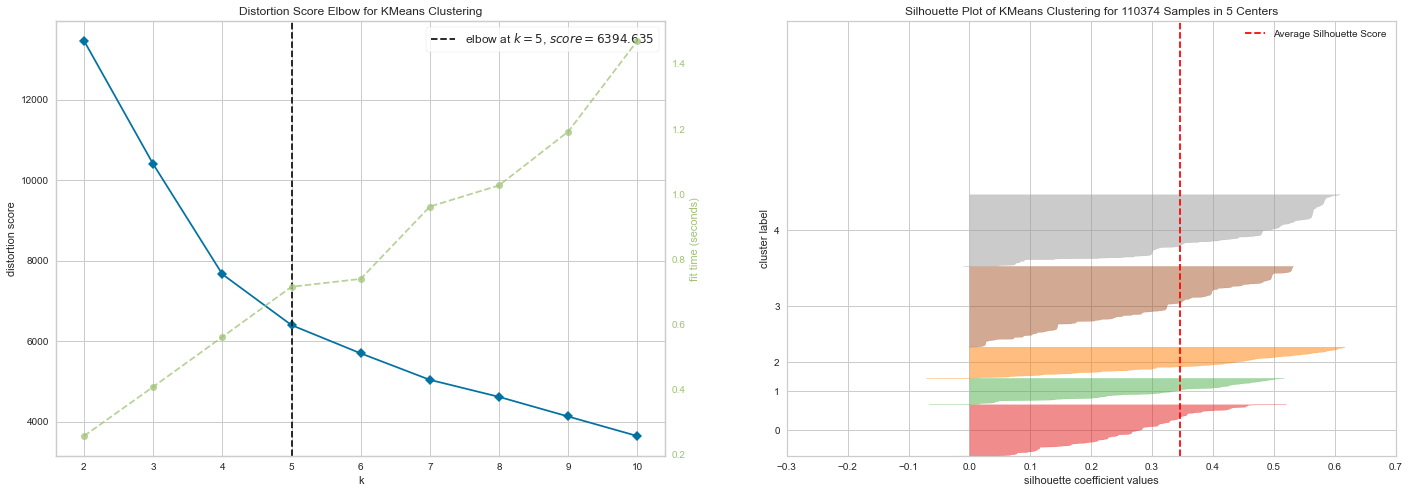

In [231]:
K = clustering_eval(preprocessor=MinMaxScaler(), 
                model=KMeans(), 
                data=X_bis, 
                metric="distortion",
                elbow=True,
                mds=False,
                KBest=None)

In [232]:
# KMeans Pipeline with best K
kmeans_model_bis = Pipeline([("preprocessor", MinMaxScaler()),
                             ("kmeans", KMeans(K))])
kmeans_model_bis.fit(X_bis)

# Kmeans labels
kmeans_labels_bis = kmeans_model_bis.named_steps['kmeans'].labels_

# Scale X
scaler = MinMaxScaler()
X_scaled_bis = scaler.fit_transform(X_bis)
X_scaled_bis = pd.DataFrame(X_scaled_bis, index=X_bis.index, columns=X_bis.columns)
X_scaled_bis["kmeans_label"] = kmeans_labels_bis

# Group by cluster
X_scaled_clusters_bis = X_scaled_bis.groupby("kmeans_label").mean()

# Plot Radar chart
plot_radars(data=X_scaled_clusters_bis,
            group="kmeans_label")

- GROUPE1 : cluster 0 : Sont des clients qui passent des commandes tard dans la journée. Ces clients sont géographiquement peu éloignés et les délais de livraison sont courts. Leurs niveau de satisfaction est moyen. 




- GROUPE2 : cluster 1 : Sont des client trés satisfaits, mais qui ont trés peu dépensé sur le site. Géographiquement, ils sont trés proches du siége de OLIST.




- Groupe3 : cluster 2 : Ce sont des clients mécontants (les avis sont mauvais). Ce sont cependant les clients qui ont le plus dépensé et qui utilisent plusieurs moyens de paiement et un nombre important d'échéances. 





- Groupe4 : cluster 3 : Ce sont des clients potentiels, leurs avis sont trés bons, ils ont dépensés des sommes importantes sur le site et avec un nombre important d'échéances. Ces clients sont géographiquement très éloignés donc les délais de livraison et les frais de port sont importants.  







- Groupe5 : cluster 4 : Ce sont des client infidéles mais qui ont bien appréciés leur expérience avec l'achat sur le site de OLIST.

### Analyse en composantes principales (ACP) :

- Standarisation des données:

In [233]:
from sklearn.preprocessing import StandardScaler

In [234]:
import pandas as pd
import numpy as np
from sklearn import decomposition
from sklearn import preprocessing
from sklearn.decomposition import PCA

In [235]:
# PCA Pipeline
pca = Pipeline([("preprocessor", MinMaxScaler()),
                ("pca", PCA(svd_solver='full'))])
pca.fit(X_bis)
X_projected = pca.transform(X_bis)

- Eboulis des valeurs propres

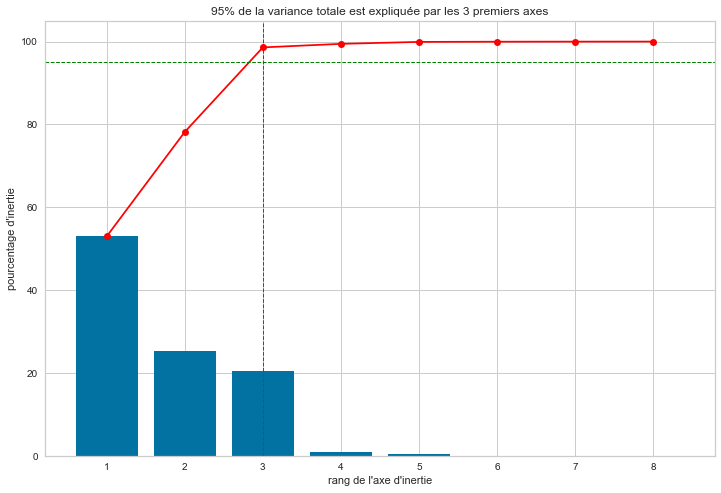

In [236]:
# Explained variance
varexpl = pca.named_steps['pca'].explained_variance_ratio_*100

# Plot of cumulated variance
plt.figure(figsize=(12,8))
plt.bar(np.arange(len(varexpl))+1, varexpl)

cumSumVar = varexpl.cumsum()
plt.plot(np.arange(len(varexpl))+1, cumSumVar,c="red",marker='o')
plt.axhline(y=95, linestyle="--", 
            color="green",
            linewidth=1)

limit = 95
valid_idx = np.where(cumSumVar >= limit)[0]
min_plans = valid_idx[cumSumVar[valid_idx].argmin()]+1
plt.axvline(x=min_plans, linestyle="--", 
            color="green",
            linewidth=1)

plt.xlabel("rang de l'axe d'inertie")
plt.xticks(np.arange(len(varexpl))+1)
plt.ylabel("pourcentage d'inertie")
plt.title("{}% de la variance totale est expliquée"\
          " par les {} premiers axes".format(limit,
                                            min_plans))
plt.show(block=False)

- Il faut donc conserver 3 axes principaux pour expliquer la variance à 95%

#### Cercle des corrélations

In [238]:
def cerle_corr(pcs, n_comp, pca, axis_ranks, 
               labels=None, label_rotation=0):
    
    fig=plt.figure(figsize=(20,n_comp*5))
    count=1
    for d1, d2 in axis_ranks:
        if d2 < n_comp:
            
            # initialisation de la figure
            #fig.subplots_adjust(left=0.1,right=0.9,bottom=0.1,top=0.9)
            ax=plt.subplot(int(n_comp/2),2,count)
            ax.set_aspect('equal', adjustable='box') 
            
            #détermination des limites du graphique
            ax.set_xlim(-1,1) 
            ax.set_ylim(-1,1) 

            #affichage des flèches 
            ax.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                       pcs[d1,:],pcs[d2,:], 
                       angles='xy', scale_units='xy', scale=1, 
                       color="grey", alpha=0.5)
            # et noms de variables
            for i,(x,y) in enumerate(pcs[[d1,d2]].T):
                ax.annotate(labels[i],(x,y),
                             ha='center', va='center',
                             fontsize='14',color="#17aafa", alpha=0.8) 

            #ajouter les axes 
            ax.plot([-1,1],[0,0],linewidth=1, color='grey', ls='--') 
            ax.plot([0,0],[-1,1],linewidth=1, color='grey', ls='--')

            #ajouter un cercle 
            cercle = plt.Circle((0,0),1,color='#17aafa',fill=False) 
            ax.add_artist(cercle) 

            # nom des axes, avec le pourcentage d'inertie expliqué
            ax.set_xlabel('F{} ({}%)'.format(d1+1, 
                                          round(100*pca.explained_variance_ratio_[d1],1)))
            ax.set_ylabel('F{} ({}%)'.format(d2+1, 
                                          round(100*pca.explained_variance_ratio_[d2],1)))

            ax.set_title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
            count+=1
            
    plt.suptitle("Cercles des corrélations sur les {} premiers axes".format(n_comp),
                 y=.9, color="blue", fontsize=18)        
    plt.show(block=False)

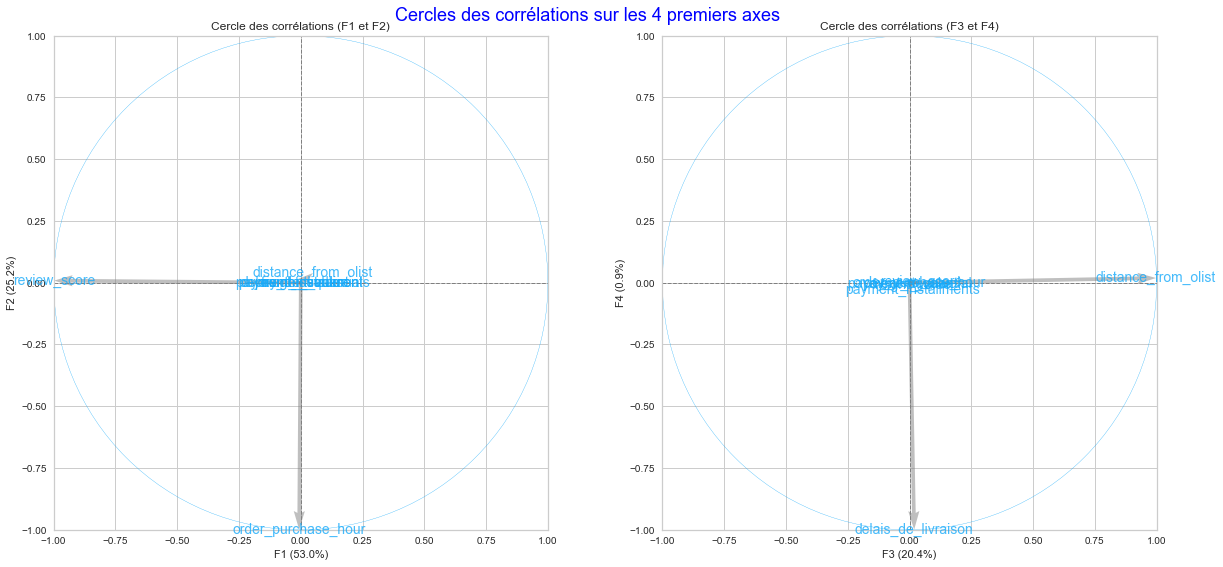

In [239]:
# Principal component space
pcs = pca.named_steps['pca'].components_

# Plot correlation circle
cerle_corr(pcs,
           4,
           pca.named_steps['pca'],
           [(0,1),(2,3)],
           labels = np.array(X_bis.columns))

- Nous allons donc intégrer à notre pipeline Kmeans une PCA sur 3 composantes pour vérifier si la réduction dimensionnelle réduit la qualité de la segmentation :

#### K-Means après réduction de dimenssions

In [243]:
# KMeans Pipeline with best K for PCA results
kmeans_model_pca = Pipeline([("preprocessor", MinMaxScaler()),
                             ("kmeans", KMeans(K))])
kmeans_model_pca.fit(X_projected[:,:2])

# Kmeans labels
pca_kmeans_labels = kmeans_model_pca.named_steps['kmeans'].labels_
X_scaled_bis["kmeans_label_pca"] = pca_kmeans_labels
X_scaled_clusters_pca = X_scaled_bis.groupby("kmeans_label_pca").mean()
X_scaled_clusters_pca.iloc[:,:-1]

,payment_value,review_score,payment_installments,order_purchase_hour,freight_value,payment_sequential,distance_from_olist,delais_de_livraison
kmeans_label_pca,,,,,,,,
0,0.001173,0.955733,0.019184,0.483758,0.006019,0.001007,0.246139,0.543052
1,0.001961,0.056663,0.026324,0.643292,0.007845,0.001460,0.266684,0.538390
2,0.001138,0.998565,0.019399,0.822974,0.005900,0.000920,0.227974,0.542392
3,0.001174,0.857870,0.022608,0.064892,0.006448,0.001229,0.260812,0.543598
4,0.001244,0.652826,0.020738,0.736457,0.006384,0.001020,0.250577,0.544198


In [244]:
plot_radars(data=X_scaled_clusters_pca.iloc[:,:-1],
            group="kmeans_label_pca")

5

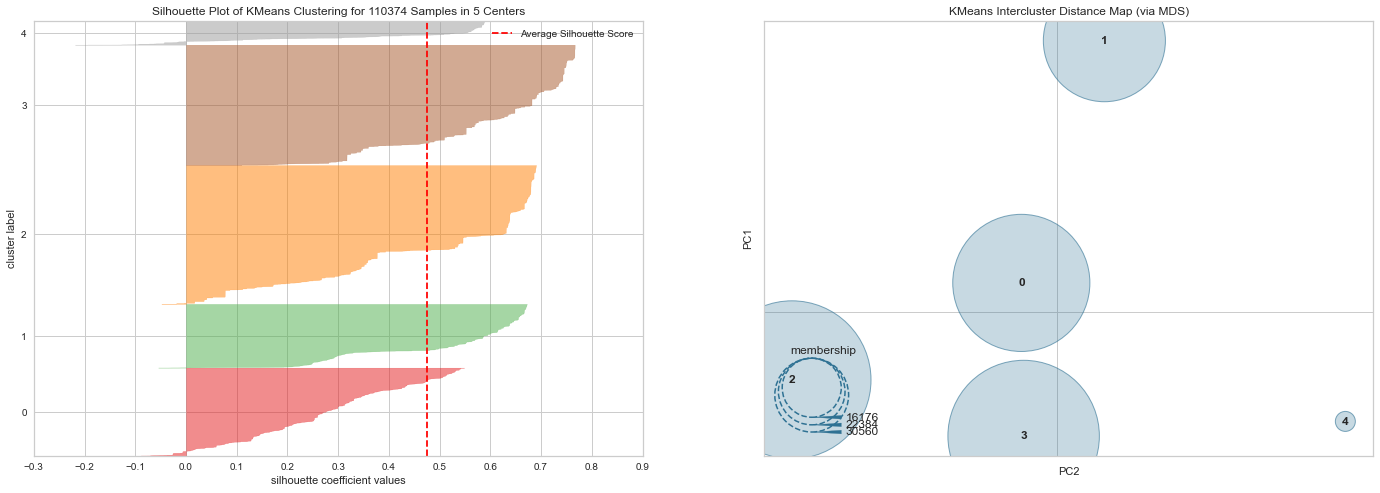

In [246]:
clustering_eval(preprocessor=MinMaxScaler(), 
                model=KMeans(), 
                data=X_projected[:,:2], 
                metric="distortion",
                elbow=False,
                mds=True,
                KBest=K)

On remarque donc ici que la réduction de dimenssion offre les mêmes axes de segmentation. Il est donc possible de réduire le nombre de features en entrée et d'utiliser les variables synthétiques de la PCA pour segmenter notre fichier client, ce d'autant que les scores silhouette sont ici meilleurs comparés au données brutes.